In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Reading in 23andMe data

In [54]:
def load_23andme(path, gt_col):
    df = pd.read_csv(
        path,
        header=None,
        names=["rsid", "chrom", "pos", gt_col],
        sep="\t",           
        dtype={"chrom": "string"},
        na_values=["", "NA", "NaN", "--", "II", "DD", "DI"])

    df["chrom"] = (df["chrom"].str.strip().str.replace("^chr", "", regex=True)   .str.replace("^M$", "MT", regex=True)  )

    df["pos"] = pd.to_numeric(df["pos"], errors="coerce").astype("Int64")

    df[gt_col] = df[gt_col].astype("string").str.strip()

    df = df[
        df["chrom"].isin([str(i) for i in range(1, 23)]) &
        df[gt_col].notna()
    ].dropna(subset=["pos"])

    sample_name = gt_col.replace("_gt","")
    df["name"] = sample_name
    
    return df

josh = load_23andme("/Users/lanceoconnor/Downloads/5-PGP-genotype-files/genome_Joshua_Yoakem_v5_Full_20250129211749.txt.corrected.txt", "josh_gt")
user5105 = load_23andme("/Users/lanceoconnor/Downloads/5-PGP-genotype-files/user5105_file3621_yearofbirth_unknown_sex_XX.23andme.txt.corrected.txt", "user5105_gt")
user5107 = load_23andme("/Users/lanceoconnor/Downloads/5-PGP-genotype-files/user5107_file3623_yearofbirth_1986_sex_XX.23andme.txt.corrected.txt", "user5107_gt")
user5902 = load_23andme("/Users/lanceoconnor/Downloads/5-PGP-genotype-files/user5902_file4372_yearofbirth_1983_sex_XX.23andme.txt.corrected.txt", "user5902_gt")
user5917 = load_23andme("/Users/lanceoconnor/Downloads/5-PGP-genotype-files/user5917_file4386_yearofbirth_1979_sex_XX.23andme.txt.corrected.txt", "user5917_gt")

In [55]:
print(josh.head())

          rsid chrom     pos josh_gt  name
0  rs548049170     1   69869      TT  josh
1    rs9283150     1  565508      AA  josh
2  rs116587930     1  727841      GG  josh
3    rs3131972     1  752721      GG  josh
4   rs12184325     1  754105      CC  josh


## Reformatting data to a matrix

In [56]:
# print(josh.head())
dfs = [josh, user5105, user5107, user5902, user5917]
gt_cols = ["josh_gt", "user5105_gt", "user5107_gt", "user5902_gt", "user5917_gt"]

long = pd.concat([d[["rsid", "chrom", "pos", "name", c]].rename(columns={c: "gt"}) for d, c in zip(dfs, gt_cols)], ignore_index = True)
 
long["locus"] = long["chrom"].astype(str) + "_" + long["pos"].astype(str)

a = long["gt"].str.slice(0, 1)
b = long["gt"].str.slice(1, 2)

allele_long = pd.concat([long[["name", "locus"]].assign(allele = a), long[["name", "locus"]].assign(allele = b),], ignore_index = True)

allele_long = allele_long[allele_long["allele"].isin(list("ACGT"))].copy()
allele_long["n"] = 1

# Count alleles per person per locus
counts = (allele_long.groupby(["name", "locus", "allele"], as_index=False)["n"].sum())

# Pivot to wide (will include only observed allele columns initially)
wide = counts.pivot(index="name", columns=["locus", "allele"], values="n").replace(np.nan, 0)

# Force ALL loci × {A,C,G,T} columns (even if never observed)
all_loci = pd.Index(long["locus"].unique(), name="locus")
all_alleles = pd.Index(list("ACGT"), name="allele")
full_cols = pd.MultiIndex.from_product([all_loci, all_alleles], names=["locus", "allele"])

wide = wide.reindex(columns=full_cols, fill_value=0).astype(int)

# Flatten columns to "chrom_pos_allele"
wide.columns = [f"{locus}_{allele}" for locus, allele in wide.columns]

# Result: N_people x (N_snps*4)
matrix = wide

In [57]:
# print(long.tail())
# print(allele_long.tail())
# print(counts[counts["n"] == 2].head())
# print(wide.head(n=1))
print(f'The shape of the final matrix is {matrix.shape[0]} rows and {matrix.shape[1]} columns')
print(matrix.index)

The shape of the final matrix is 5 rows and 4216716 columns
Index(['josh', 'user5105', 'user5107', 'user5902', 'user5917'], dtype='object', name='name')


# Reading in Seldin data

In [58]:
df = pd.read_csv('/Users/lanceoconnor/Downloads/Seldin_AIMS_SNPs.csv', names=["rsid","snp_assay","strand","VIC","FAM","context","chrom","assembly","pos"], header = 0)

# The number of individuals missing a SNP for each SNP in the AIM dataset

In [59]:
aims_loci_set = df["rsid"]

def missing_AIM_snp_person(person_23andme, aims_loci):
    person_snps = person_23andme["rsid"]

    person_snps_dict = {locus: "NA" for locus in person_snps}
    aims_loci_dict = {locus: "NA" for locus in aims_loci}

    for key in aims_loci_dict.keys():
        if key not in person_snps_dict.keys():
            aims_loci_dict[key] = 0
        else:
            aims_loci_dict[key] = 1

    return(aims_loci_dict)

josh_missing_aims = pd.DataFrame((missing_AIM_snp_person(josh, aims_loci_set)).items(), columns=["aims_snp", "josh_has_snp"])
user5105_missing = pd.DataFrame((missing_AIM_snp_person(user5105, aims_loci_set)).items(), columns=["aims_snp", "user5105_has_snp"])
user5107_missing = pd.DataFrame((missing_AIM_snp_person(user5107, aims_loci_set)).items(), columns=["aims_snp", "user5107_has_snp"])
user5902_missing = pd.DataFrame((missing_AIM_snp_person(user5902, aims_loci_set)).items(), columns=["aims_snp", "user5902_has_snp"])
user5917_missing = pd.DataFrame((missing_AIM_snp_person(user5917, aims_loci_set)).items(), columns=["aims_snp", "user5917_has_snp"]) 

final_join = josh_missing_aims.merge(user5105_missing, on="aims_snp").merge(user5107_missing, on="aims_snp").merge(user5902_missing, on="aims_snp").merge(user5917_missing, on="aims_snp")
# print(final_join.head(n=2))
# print(len(final_join))

# Plotting number of people missing each AIM SNP

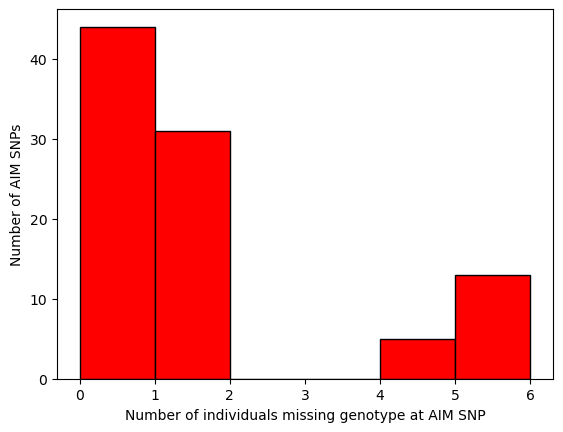

The number of AIM SNPs that are missing in all 5 individuals is 13


In [60]:
presence_matrix = final_join.drop(columns=["aims_snp", "n_missing"], errors="ignore")
final_join["n_missing"] = (presence_matrix == 0).sum(axis=1)

plt.hist(final_join["n_missing"], bins = range(0,7), color = 'red', edgecolor = 'k')
plt.xlabel("Number of individuals missing genotype at AIM SNP")
plt.ylabel("Number of AIM SNPs")
plt.show()

print(f'The number of AIM SNPs that are missing in all 5 individuals is {sum(final_join["n_missing"] == 5)}')

# Writing code to plot PCA

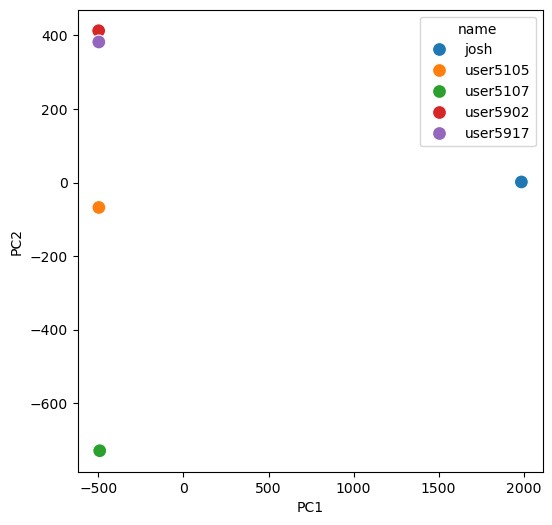

In [61]:
X = matrix.to_numpy()
# print(X)
sample_names = matrix.index.to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)
# # X_pca.shape #(5x2)

pca_df = pd.DataFrame({
    "name" : sample_names,
    "PC1" : X_pca[:,0],
    "PC2" : X_pca[:,1]
})

plt.figure(figsize=(6,6))
sns.scatterplot(data = pca_df, x="PC1", y="PC2", hue="name", s=100)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [62]:
file_list = glob.glob("/Users/lanceoconnor/Downloads/33_snps/33-PGP-genotype-files/*.corrected.txt")

long_33_table = pd.DataFrame()

for file in file_list:
    name = os.path.basename(file).split(".")[0]
    gt_col = name + "_gt"
    
    tmp = load_23andme(file, gt_col)
    tmp = tmp.rename(columns={gt_col: "gt"})
    long_33_table = pd.concat([long_33_table, tmp], ignore_index=True)

In [ ]:
long_33_table['ethnicity'] = long_33_table['name'].str.split("_").str[2]

person_eth = long_33_table[["name", "ethnicity"]].drop_duplicates()
print(person_eth)

In [ ]:
long_33_table["locus"] = long_33_table["chrom"].astype(str) + "_" + long_33_table["pos"].astype(str)

a = long_33_table["gt"].str.slice(0, 1)
b = long_33_table["gt"].str.slice(1, 2)

allele_long = pd.concat([long_33_table[["name", "locus"]].assign(allele = a), long_33_table[["name", "locus"]].assign(allele = b),], ignore_index = True)

allele_long = allele_long[allele_long["allele"].isin(list("ACGT"))].copy()
allele_long["n"] = 1

# Count alleles per person per locus
counts = (allele_long.groupby(["name", "locus", "allele"], as_index=False)["n"].sum())

# Pivot to wide (will include only observed allele columns initially)
wide = counts.pivot(index="name", columns=["locus", "allele"], values="n").replace(np.nan, 0)

# Force ALL loci × {A,C,G,T} columns (even if never observed)
all_loci = pd.Index(long_33_table["locus"].unique(), name="locus")
all_alleles = pd.Index(list("ACGT"), name="allele")
full_cols = pd.MultiIndex.from_product([all_loci, all_alleles], names=["locus", "allele"])

wide = wide.reindex(columns=full_cols, fill_value=0).astype(int)

# Flatten columns to "chrom_pos_allele"
wide.columns = [f"{locus}_{allele}" for locus, allele in wide.columns]

# Result: N_people x (N_snps*4)
matrix = wide

In [ ]:
print(matrix.shape)

(33, 7965392)


In [ ]:
X = matrix.to_numpy()
# print(X)
sample_names = matrix.index.to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)
# # X_pca.shape #(5x2)

pca_df = pd.DataFrame({
    "name" : sample_names,
    "PC1" : X_pca[:,0],
    "PC2" : X_pca[:,1]
})

pca_df = pca_df.merge(person_eth, on="name")

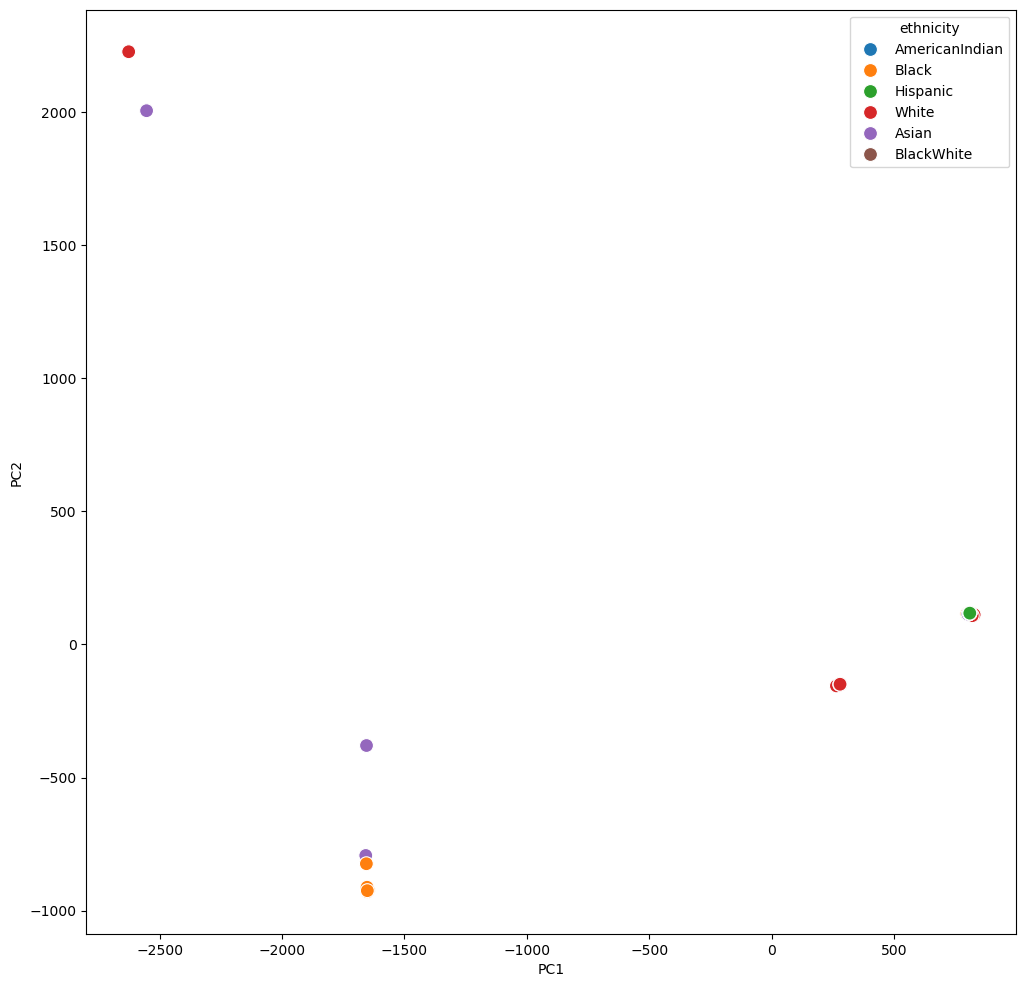

In [ ]:
plt.figure(figsize=(12,12))
sns.scatterplot(data = pca_df, x="PC1", y="PC2", s=100, hue = "ethnicity")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()